--- 
description: The Travelling Salesman Problem (TSP) is the problem of finding the shortest tour salesman to visit every city.
---

# Traveling Salesman Problem

The Travelling Salesman Problem (TSP) is the problem of finding the shortest tour salesman to visit every city. 
It is known as an NP-hard problem. 
There are several well-known linear formulations for TSP.
However, here we show a quadratic formulation for TSP because it is more suitable for Annealing.

## Mathematical model

Let's consider $n$-city TSP.

### Decision variable

A binary variables $x_{i,t}$ are defined as:
$$
x_{i,t} = \begin{cases}
1~\text{the salesman visits $t$-th city $i$,}\\
0~\text{otherwise}\\
\end{cases}
$$
for all $i \in \{0, ..., n-1\}$ and $t \in \{0, ..., n-1\}$.
$x_{i,t}$ represents the salesman visits city $i$ at $t$ when it is 1.

### Constraints

We have to consider two constraints;

1. A city is visited only once.
$$
\sum_t x_{i, t} = 1, ~\forall i
$$

2. The salesman visits only one city at a time.
$$
\sum_i x_{i, t} = 1, ~\forall t 
$$

The following figure illustrates why these two constraints are needed for $x_{i,t}$ to represent a tour.

![](./assets/tsp_variable.png)

### Objective function

The total distance of the tour, which is an objective function to be minimized, can be written as follows using the product of $x$ representing the edges used between $t$ and $t+1$.

$$
\sum_{i,j,t} d_{i, j}x_{i, t}x_{j, (t+1)\mod n}
$$
where $d_{i, j} \geq 0$ is a distance between city $i$ and city $j$.
"$\mod n$" is used to include in the sum the distance from the last city visited back to the first city visited. For example, when $n$ is equal to 5 and node $0$ is the first city visited, $x_{0, (4+1)\mod 5}$ means $x_{0, 0}$.


## $n$-city TSP.
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n}\\
\mathrm{s.t.}~&\sum_i x_{i, t} = 1,~\forall t\\
&\sum_t x_{i, t} = 1, ~\forall i\\
&x_{i, t} \in \{0, 1\}
\end{aligned}
$$
where $d_{i,j}$ is distance between city $i$ and city $j$.

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

# define variables
d = jm.Placeholder('d', ndim=2)
N = d.len_at(0, latex="N")
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, N))
t = jm.Element('t', belong_to=(0, N))
x = jm.BinaryVar('x', shape=(N, N))

`d` is a two-dimensional array representing the distance between each city.
`N` denotes the number of cities. This can be obtained from the number of rows in `d`.
`i`, `j` and `t` are subscripts used in the mathematical model described above.
Finally, we define the binary variable `x` to be used in this optimization problem.


<!-- `d`は2次元の距離行列で、都市間の距離を表すものです。`N`は都市数で、これは`d`の行数から得ることができます。`i, j, t`は上述の数理モデルで使われている添字です。
最後に、この最適化問題で用いるバイナリ変数`x`を定義しています。 -->

In [2]:
# set problem
problem = jm.Problem('TSP')
problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N]))
problem += jm.Constraint("one-city", x[:, t].sum() == 1, forall=t)
problem += jm.Constraint("one-time", x[i, :].sum() == 1, forall=i)

`jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N]))` represents objective function $\sum_{i,j,t} d_{i, j}x_{i, t}x_{j, (t+1)\mod n}$. 
The following `jm.Constraint("one-city", x[:, t] == 1, forall=t)` represents a constraint to visit one city at one time.
`x[:, t]` allows us to express $\sum_i x_{i, t}$ concisely.


<!-- `jm.Sum([i, j], d[i, j] * jm.Sum(t, x[i, t]*x[j, (t+1) % N]))`は目的関数$\sum_{i,j,t} d_{i, j}x_{i, t}x_{j, (t+1)\mod n}$を表します。
次の`jm.Constraint("one-city", x[:, t] == 1, forall=t)`は一つの時刻に一つの都市を訪れる制約を表します。`x[:, t]`とすることで$\sum_i x_{i, t}$を簡潔に表現することができます。 -->

We can check the implementation of the mathematical model on the Jupyter Notebook.

In [3]:
problem

## Prepare an instance

We prepare the number of cities and their coordinates. 
Here we select a metropolitan area in Japan using `geocoder`.

<!-- 都市の数と座標を準備しましょう。ここでは日本の首都圏を`geocoder`を用いて選び出します。 -->

In [4]:
from geopy.geocoders import Nominatim
import numpy as np

geolocator = Nominatim(user_agent='python')

# set the name list of traveling points
points = ['茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県']

# get the latitude and longitude
latlng_list = []
for point in points:
    location = geolocator.geocode(point)
    if location is not None:
        latlng_list.append([ location.latitude, location.longitude ])
# make distance matrix
num_points = len(points)
inst_d = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        a = np.array(latlng_list[i])
        b = np.array(latlng_list[j])
        inst_d[i][j] = np.linalg.norm(a-b)
# normalize distance matrix
inst_d = (inst_d-inst_d.min()) / (inst_d.max()-inst_d.min())

geo_data = {'points': points, 'latlng_list': latlng_list}
instance_data = {'d': inst_d}

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [5]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="config.toml")
# solve problem
multipliers = {"one-city": 0.5, "one-time": 0.5}
response = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Check the results

First, check the results of the evaluation.

In [7]:
# get sampleset
sampleset = response.get_sampleset()
# get the values of objective function
# The number of samples is the same as num_reads multiplied by num_search (If search=True)
objectives = [sample.eval.objective for sample in sampleset]
# get the values of constraint vlolation
one_city_violations = [sample.eval.constraints["one-city"].total_violation for sample in sampleset]
one_time_violations = [sample.eval.constraints["one-time"].total_violation for sample in sampleset]
# set the number of showing result
# resutls are not sorted, so the lower objective value does not always come first
max_show_num = 5
# show the results
print("Objective: ", objectives[:max_show_num])
print("One-city violation: ", one_city_violations[:max_show_num])
print("One-time violation: ", one_time_violations[:max_show_num])

Objective:  [1.9436576668549268, 1.045598017309573, 1.045598017309573, 1.8834731017537, 1.9436576668549268]
One-city violation:  [1.0, 2.0, 3.0, 1.0, 1.0]
One-time violation:  [1.0, 2.0, 1.0, 1.0, 1.0]


### Extract feasible solutions and an index of the lowest solution

From the results, we extract the feasible solutions and show the lowest value of the objective function among them.

Note: There is a possibility that the solutions which violates constraints are included in the results.

In [8]:
import numpy as np

# extract feasible solutions
feasible_samples = sampleset.feasibles()
# get the value of feasible objective function
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
# get the lowest value of objective function
lowest_index = np.argmin(feasible_objectives)
# show the result
print(f"Lowest solution index: {lowest_index}, Lowest objective value: {feasible_objectives[lowest_index]}")

Lowest solution index: 0, Lowest objective value: 2.8774493667284857


## Draw tour

In [28]:
# get the indices of x == 1
x_indices = feasible_samples[lowest_index].var_values["x"].values.keys()
# sort by time step
tour = [index for index, _ in sorted(x_indices, key=lambda x: x[1])]
tour.append(tour[0])
tour

[6, 5, 4, 0, 1, 2, 3, 6]

We check the salesman’s route.

[[140.4703384 139.8096549 139.033483  139.4160114 140.2647303 139.762221
  139.374753 ]
 [ 36.2869536  36.6782167  36.52198    35.9754168  35.549399   35.6821936
   35.4342935]]


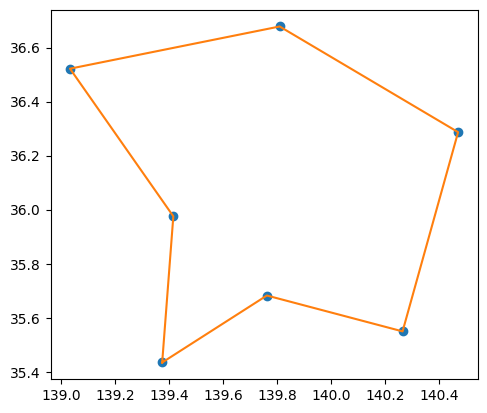

['神奈川県' '東京都' '千葉県' '茨城県' '栃木県' '群馬県' '埼玉県' '神奈川県']


In [24]:
import matplotlib.pyplot as plt

position = np.array(geo_data['latlng_list']).T[[1, 0]]

print(position)

plt.axes().set_aspect('equal')
plt.plot(*position, "o")
plt.plot(position[0][tour], position[1][tour], "-")
plt.show()

print(np.array(geo_data['points'])[tour])